In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
from functions import get_dyn_v2, get_prop_abs_v2, create_R_v1, get_var_hist,simulate_traj, get_p_x4_short_time, get_steady_mean
from setup import setup_matplotlib, one_col, std_height, two_col
from timeit import default_timer as timer

setup_matplotlib()

np.random.seed(42)

In [3]:
k = 1
s = 1
D = s**2/2
#N_t = 100
max_t = 6
ntau = 3
# dx = 0.2
N_x = 21

f = 30
N_p = 2_000
N_loop = 10


#x_s = np.arange(-sb,sb+1e-6,dx)
#bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
#N_x = len(x_s)

def force(x,*args):
     return -k*x**3

ltaus = np.concatenate(([0.05], np.arange(0.1,1.1,0.1) ))
#ltaus = [0.05]
sim_vars = np.empty((len(ltaus),2))
num_vars = np.empty((len(ltaus),2))
sim_hist_vars = np.empty((len(ltaus),2))
short_time_approx_var = np.empty(len(ltaus))
escaped_traj = np.empty(len(ltaus))
sbs = np.empty(len(ltaus))

sim_times = np.empty(len(ltaus))
num_times = np.empty(len(ltaus))

In [4]:
for i,ltau in enumerate(tqdm(ltaus)): 
    start = timer()
    ldt = ltau/ntau
    N_t = max(int(max_t/ldt), 30)
    
    
    pos = simulate_traj(N_p=N_p, N_loop=N_loop, N_t=(N_t+ntau+2)*f, ntau=ntau*f, s=s, dt=ldt/f,border=0, force=force)
    pos_filter = pos.copy()
    pos_filter[pos_filter**2 > 7/4/ltau] = np.nan
    sim_var = np.nanvar(pos_filter, axis = 1)

    # adapt boundaries to varianz (from sim) -> 3 sigma
    sb = 3*np.sqrt(np.max(sim_var))
    sbs[i] = sb
    #sb = min(20*dx, np.round(sb/dx)*dx)
    dx = 2*sb/(N_x-1)
    
    x_s = np.arange(-sb,sb+1e-6,dx)
    bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)

    
    sim_hists = np.swapaxes(np.apply_along_axis(lambda a: np.histogram(a, bins)[0], 1, pos), 1,2)
    sim_hist_var =  np.apply_along_axis(get_var_hist,-1, sim_hists, x_s=x_s)
        
    #short_time_p = get_p_x4_short_time(x_s, k,ltau,s)
    short_time_p = get_p_x4_short_time(x_s, ltau)
    short_time_approx_var[i] = get_var_hist(short_time_p,x_s)
    
    escaped_traj[i] = 1-np.sum(sim_hists[:,-1])/(N_p*N_loop)
    
    mean_sim_vars = np.mean(sim_var[:,-f*ntau*2:], axis = 1)
    sim_vars[i] = (np.mean(mean_sim_vars), np.std(mean_sim_vars)/np.sqrt(N_loop))

    mean_sim_hist_var = np.mean(sim_hist_var[:,-f*ntau*2:], axis = 1)
    sim_hist_vars[i] = (np.mean(mean_sim_hist_var), np.std(mean_sim_hist_var)/np.sqrt(N_loop))
    
    sim_times[i] = timer() - start

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10860 [00:00<?, ?it/s]

  0%|          | 0/5460 [00:00<?, ?it/s]

  0%|          | 0/2760 [00:00<?, ?it/s]

/tmp/ipykernel_18179/2127467668.py:20: RuntimeWarning: overflow encountered in power
  return -k*x**3
/home/nils/Programmieren/overdampedDelayHarmonicOscillator/paper/functions.py:208: RuntimeWarning: invalid value encountered in add
  pos[:,:,i] = pos[:,:,i-1] + vel[:,:,i-1]*dt
/tmp/ipykernel_18179/1144230269.py:9: RuntimeWarning: overflow encountered in square
  pos_filter[pos_filter**2 > 7/4/ltau] = np.nan


  0%|          | 0/1830 [00:00<?, ?it/s]

  0%|          | 0/1410 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/960 [00:00<?, ?it/s]

  0%|          | 0/960 [00:00<?, ?it/s]

  0%|          | 0/960 [00:00<?, ?it/s]

  0%|          | 0/960 [00:00<?, ?it/s]

  0%|          | 0/960 [00:00<?, ?it/s]

In [5]:
for i,ltau in enumerate(tqdm(ltaus)): 
    start = timer()
    ldt = ltau/ntau
    N_t = max(int(max_t/ldt), 30)
    
    sb = sbs[i]
    dx = 2*sb/(N_x-1)
    
    x_s = np.arange(-sb,sb+1e-6,dx)
    i_zero = np.argmin(x_s**2)

    prop = get_prop_abs_v2(x_s, force,D,ldt,dx, side = 'lr')
    R, _, end_states = create_R_v1(N_x, ntau, prop)
    _, hists = get_dyn_v2(R, i_zero,N_t, N_x, ntau, end_states)
    num_var = get_var_hist(hists, x_s)

    mean_num_var = np.mean(num_var[-ntau*2:])
    num_vars[i] =  (mean_num_var, np.max(num_var[-ntau*2:])-np.min(num_var[-ntau*2:]))

    num_times[i] = timer()-start

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

In [6]:
# with open(f'nummeric_results/sim_vs_num_v4_emb{tau_frac}_x4.pkl', 'wb') as file:
#     pickle.dump({'ltaus':ltaus,
#                  'sim_vars':sim_vars,
#                  'sim_hist_vars':sim_hist_vars,
#                  'num_vars':num_vars
#                 }, file)

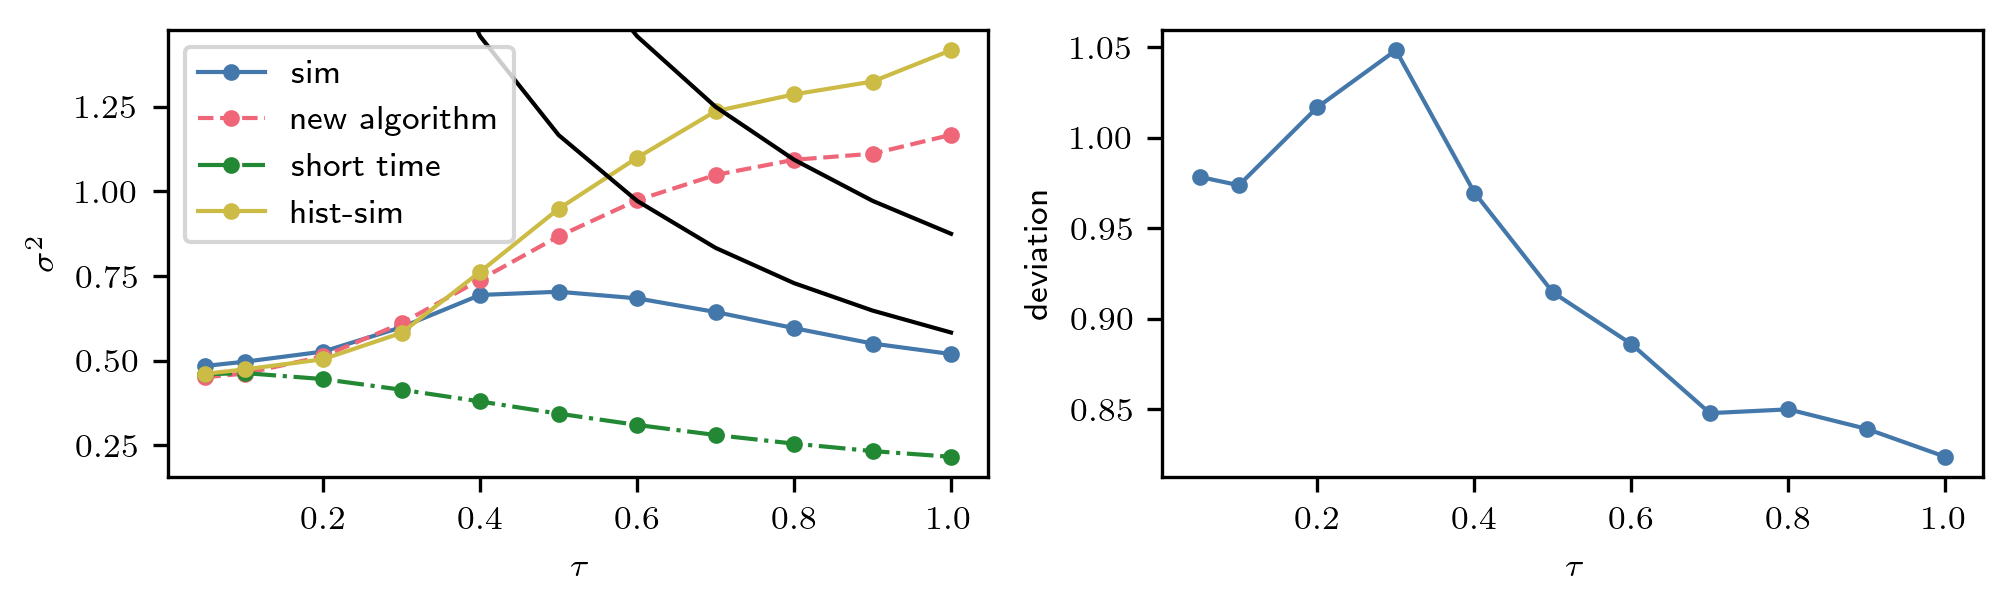

In [12]:
plt.figure(figsize=(two_col,std_height))
ax = plt.subplot(121)
plt.plot(ltaus,sim_vars[:,0],'.-', label='sim')

plt.plot(ltaus,num_vars[:,0],'.--', label='new algorithm')



plt.plot(ltaus,short_time_approx_var ,'.-.',label='short time')

plt.plot(ltaus,sim_hist_vars[:,0],'.-', label='hist-sim')

#plt.yscale('log')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\sigma^2$')
plt.ylim(*plt.ylim())
#auflösungslimit std same as div x0
# plt.plot(ltaus, (2/3)**2*ltaus**(-1), color = 'black')
plt.plot(ltaus, (np.sqrt(7)/2)**2*ltaus**(-1), color = 'black')
plt.plot(ltaus, 1/2*(np.sqrt(7)/2)**2*ltaus**(-1), color = 'black')
plt.plot(ltaus, 1/3*(np.sqrt(7)/2)**2*ltaus**(-1), color = 'black')
# plt.xlim(0,0.2)
# plt.ylim(0.4,0.6)

ax = plt.subplot(122)
plt.plot(ltaus, num_vars[:,0]/sim_hist_vars[:,0], '.-')
plt.xlabel(r'$\tau$')
plt.ylabel(r'deviation')

plt.tight_layout()
plt.savefig(f'graphics/x4variance_Nx{N_x}_ntau{ntau}.pdf')

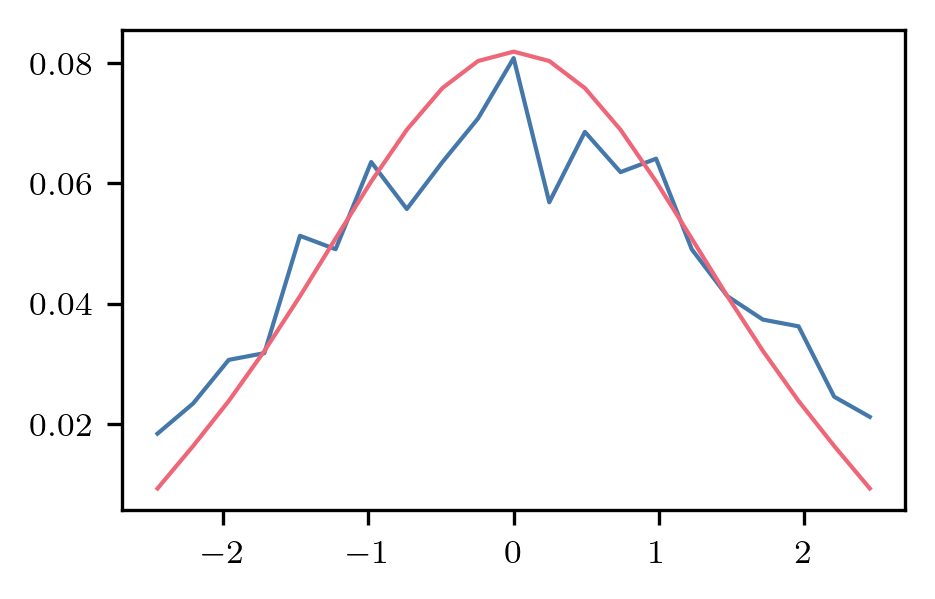

In [8]:
plt.plot(x_s,sim_hists[:,-1].sum(0)/sim_hists[:,-1].sum())
plt.plot(x_s,hists[-1]/hists[-1].sum())
#plt.vlines(-np.sqrt(7)/2/np.sqrt(ltau), *plt.ylim())

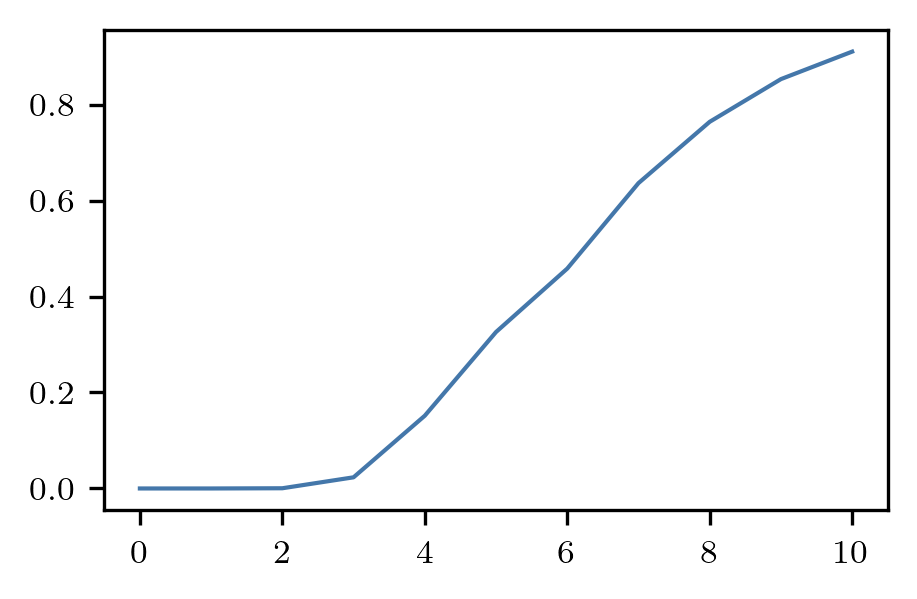

In [9]:
plt.plot(escaped_traj)

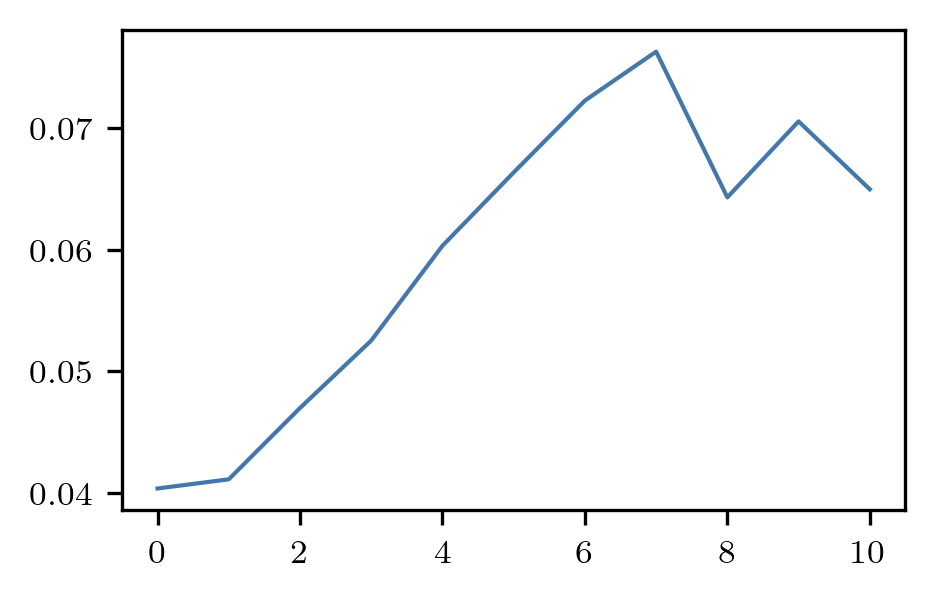

In [10]:
plt.plot(num_times/sim_times)

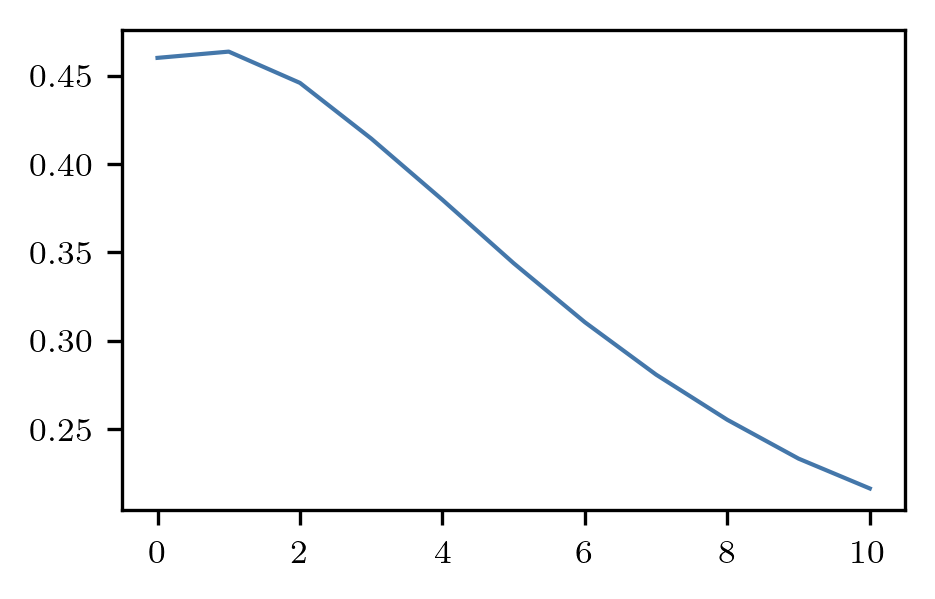

In [11]:
plt.plot(short_time_approx_var)

# Test short time approx -- approved

In [12]:
# dt = 0.01
# N_loop = 10
# N_p = 2_000
# N_t = 5_000
# N_x = 50

# ltaus = np.concatenate(([0.05], np.arange(0.1,1.1,0.1) ))
# #ltaus = [0.05]
# sim_vars = np.empty((len(ltaus),2))
# sim_hist_vars = np.empty((len(ltaus),2))
# short_time_approx_var = np.empty(len(ltaus))

# for i, tau in enumerate(tqdm(ltaus)):
#     def f_a(x):
#         return -x**3*(1 + 3*tau*x**2)
#     def g_a(x):
#         return (1 + 3*tau*x**2)
    
#     pos = np.empty((N_loop,N_p,N_t))
#     vel = np.empty((N_loop,N_p,N_t))
    
#     pos[:,:,0] = 0
#     vel[:,:,0] = 0
    
#     for j in tqdm(range(1,N_t), leave=False):
#         pos[:,:,j] = pos[:,:,j-1] + vel[:,:,j-1]*dt
#         vel[:,:,j] = f_a(pos[:,:,j]) + g_a(pos[:,:,j])*1/np.sqrt(dt)*np.random.randn(N_loop,N_p)
    
#     pos_filter = pos.copy()
#     if tau > 0:
#         pos_filter[pos_filter**2 > 7/4/tau] = np.nan
#     sim_var = np.nanvar(pos_filter, axis = 1)
    
#     sb = 3*np.sqrt(np.max(sim_var))
#     dx = 2*sb/(N_x-1)
#     x_s = np.arange(-sb,sb+1e-6,dx)
#     bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
    
    
#     sim_hists = np.swapaxes(np.apply_along_axis(lambda a: np.histogram(a, bins)[0], 1, pos), 1,2)
#     sim_hist_var =  np.apply_along_axis(get_var_hist,-1, sim_hists, x_s=x_s)
    
#     short_time_p = get_p_x4_short_time(x_s, tau)
#     short_time_approx_var[i] = get_var_hist(short_time_p,x_s)

#     mean_sim_vars = np.mean(sim_var[:,-500:], axis = 1)
#     sim_vars[i] = (np.mean(mean_sim_vars), np.std(mean_sim_vars)/np.sqrt(N_loop))

#     mean_sim_hist_var = np.mean(sim_hist_var[:,-500:], axis = 1)
#     sim_hist_vars[i] = (np.mean(mean_sim_hist_var), np.std(mean_sim_hist_var)/np.sqrt(N_loop))

In [13]:
# plt.plot(sim_var[0])
# plt.plot(sim_hist_var[0])
# plt.hlines(short_time_approx_var[-1], *plt.xlim())

In [14]:
# plt.plot(short_time_approx_var)
# plt.plot(sim_hist_vars[:,0])
# plt.plot(sim_vars[:,0])